# DA5401 - ASSIGNMENT 5
## Visualizing Data Veracity Challenges in Multi-Label Classification 

#### Importing the Libraries

In [37]:
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.manifold import Isomap

### Part A: Preprocessing and Initial Setup
1. Data Loading: Loading the feature matrix X (103 features) and the multi-label target matrix Y (14 labels).
2. Dimensionality Check: Reporting the initial number of features and the number of data points.
3. Label Selection for Visualization: To simplify the visualization, creating a new target variable for coloring that represents the two most frequent single-label classes and the most frequent multi-label combination. Assigning an "other" category to the rest. This creates a simple, distinct categorical index for coloring the plots.
4. Scaling: Explaining why sacling is crucial before applying distance-based dimensionality reduction techniques. Applying Standardization to the feature matrix X.

#### Loading the Dataset

In [38]:
arff_file = "yeast.arff"   
data, meta = arff.loadarff(arff_file)

df = pd.DataFrame(data)

# Last 14 columns are labels, rest are features
X = df.iloc[:, :-14].astype(float)
Y = df.iloc[:, -14:].astype(int)

#### Dimensionality of Initial Features and Data Points

In [39]:
print("\nNumber of data points:", X.shape[0])
print("Number of features:", X.shape[1])
print("Number of labels:", Y.shape[1])


Number of data points: 2417
Number of features: 103
Number of labels: 14


##### In the given dataset:
- We got 2,417 rows of information. These are individual examples that we need to study.
- For each of those 2,417 examples, we have 103 columns describing it. These are all the characteristics to make a decision.
- While prediction, it gives 14 separate results at the same time indicated by 14 labels.

------------------------------------------------------------------------------------------------------------------------------------------------------

#### Label Reduction for Visualization

In [40]:
# Converting each row of Y into a tuple of active labels and counting frequency
label_tuples = [tuple(Y.columns[np.where(row==1)[0]]) for row in Y.to_numpy()]
combo_counts = Counter(label_tuples)

# Identify most common single labels
single_label_counts = Counter([lbl for combo in label_tuples if len(combo)==1 for lbl in combo])
top2_single = [lbl for lbl, _ in single_label_counts.most_common(2)]
if len(top2_single) < 2:
    top2_single = top2_single * 2 

# Identify most common multi-label combination
multi_combos = {combo:count for combo,count in combo_counts.items() if len(combo)>1}
top_multi = max(multi_combos, key=multi_combos.get)

print("\nTop 2 single labels:", top2_single)
print("Top multi-label combo:", top_multi)

# Create a simplified target variable
def simplify_labels(combo):
    if len(combo)==1 and combo[0] in top2_single:
        return combo[0]
    elif combo == top_multi:
        return "Top-Multi"
    else:
        return "Other"

Y_simple = [simplify_labels(combo) for combo in label_tuples]
df["Y_simple"] = Y_simple

print("\nSimplified label distribution:")
print(pd.Series(Y_simple).value_counts())


Top 2 single labels: ['Class1', 'Class1']
Top multi-label combo: ('Class3', 'Class4', 'Class12', 'Class13')

Simplified label distribution:
Other        2148
Top-Multi     237
Class1         32
Name: count, dtype: int64


##### When we simplified our labels into Y_simple, the distribution shows a highly imbalanced pattern:
- Dominant single label: Class1 appears most frequently among individuals but only 32 instances
- Dominant multi-label combination: The combination of Class3, Class4, Class12, Class13 appears together 237 times, making it the most common multi-label group
- Other labels: The vast majority, 2,148 instances, fall into the 'Other' category, indicating they either appeared infrequently or did not match the top single or multi-label groups

Our dataset is heavily skewed toward the 'Other' category, while a few single and multi-label combinations dominate the rest. This suggests that while some classes are more frequent, most labels are rare or scattered. 

----------------------------------------------------------------

#### Standardization on Matrix X

In [41]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##### Before reducing dimensions, it's important to put all features on a similar scale. If one feature has really large values while another is tiny, the algorithm will pay more attention to the bigger numbers and ignore the smaller ones. Scaling makes sure every feature gets a fair say, so the patterns and clusters we see in the reduced space actually reflect the true structure of the data.

----------------------------------------------------------------
----------------------------------------------------------------

### Part B: t-SNE and Veracity Inspection
- t-SNE Implementation: Applying t-Distributed Stochastic Neighbor Embedding (t-SNE) to the scaled feature matrix X to reduce it to 2 dimensions. Experimenting with the perplexity hyperparameter and noting visualization changes.
- Visualization:
    - Creating a 2D scatter plot of the final t-SNE coordinates
    - Coloring each data point according to the categorical index created in Part A
- Veracity Inspection: Analyzing the resulting plot and visually identifying regions corresponding to: 
    - Noisy/Ambiguous Labels: Points where one color is deeply embedded within a cluster of a different color
    - Outliers: Isolated points or tiny, distant clusters. Hypothesize what these unusual expression patterns might represent
    - Hard-to-Learn Samples: Areas where functional category colors are thoroughly mixed. Explaining why a simple classifier would likely struggle in these regions

#### t-SNE Implementation with different perplexity hyperparameter

In [42]:
perplexities = [5, 30, 50]
tsne_results = {}

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    tsne_results[p] = tsne.fit_transform(X_scaled)

##### t-SNE is a technique that helps us visualize high-dimensional data in just 2 dimensions. It tries to keep similar points close together while pushing dissimilar points apart, making clusters and patterns easier to see. Before applying it, we scale the features so that all of them contribute fairly to the analysis.

##### The perplexity parameter controls how t-SNE balances local versus global relationships or it can be taken as a measure of how many neighbors each point coniders when forming the 2D visualization. Low values focus on local patterns making plot look fragmented. High values capture broader patterns but may merge small clusters. Medium values usually give a good balance between detail and overall structure. 

----------------------------------------------------------------

#### Scatter Plot of t-SNE Coordinates

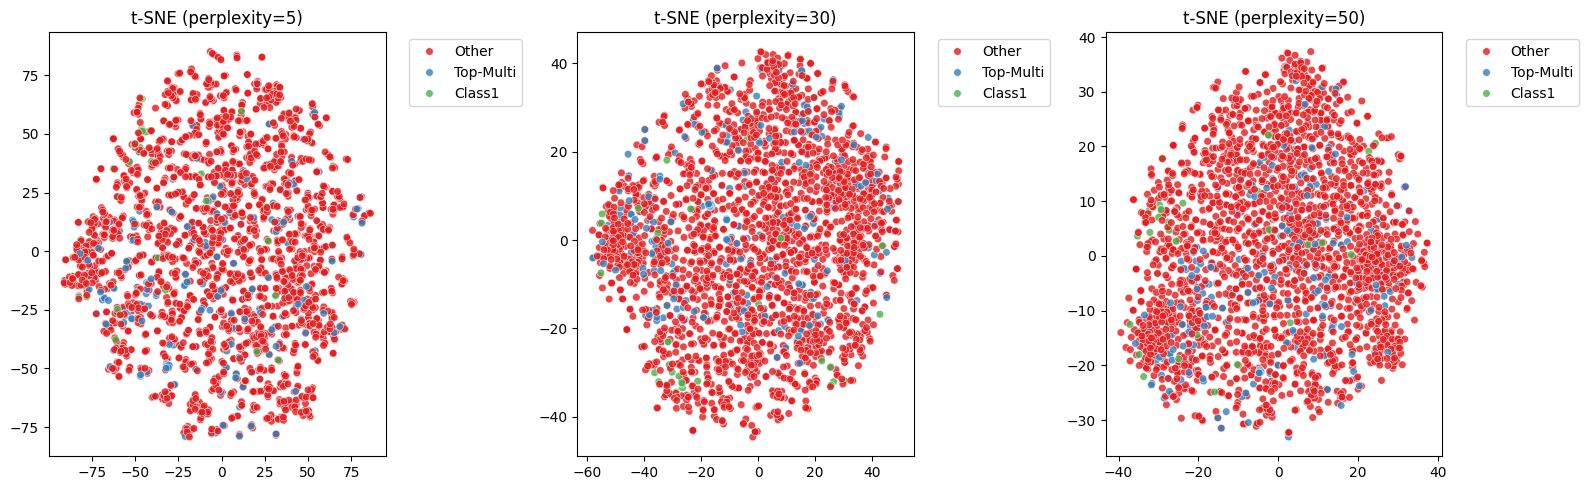

In [43]:
plt.figure(figsize=(16, 5))
for i, p in enumerate(perplexities):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(
        x=tsne_results[p][:,0], 
        y=tsne_results[p][:,1], 
        hue=df["Y_simple"], 
        palette="Set1", 
        s=30, alpha=0.8
    )
    plt.title(f"t-SNE (perplexity={p})")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

##### The 3 plots show how the t-SNE visualization changes with different perplexity values (5, 30, 50).
- Perplexity = 5: The points form many small, scattered clusters. This setting focuses too much on local relationships, so the data looks fragmented and less cohesive overall.
- Perplexity = 30: The plot becomes more structured. Clusters are clearer, and there's a better balance between local detail and the overall shape of the data. The 'Top-Multi' and 'Class1' samples are more evenly distributed among the 'Other' points, suggesting some underlying structure.
- Perplexity = 50: The plot appears smoother and slightly more compact, but smaller clusers start merging together. Some finer local distinctions become less visible.

##### Overall, perplexity = 30 provides the most interpretable visualization - it captures both the local neighborhoods and the broader organization of the dataset effectively.

----------------------------------------------------------------

#### Veracity Inspection

##### In the t-SNE visualizations, most of the data points belong to the 'Other' class (red), with a smaller number of 'Top-Multi' (blue) and 'Class1' (green) samples scattered throughout. The following observations can be made:
- Noisy/Ambiguous Labels (~ 4 regions): Across all three t-SNE plots, especially at perplexity 30 and 50, there are several small pockets where green ('Class1') and blue ('Top-Multi') points are surrounded by red ('Other') points. These represent ambiguous samples - genes whose expression patterns don't align neatly with their labeled category. They might correspond to overlapping biological pathways or mixed regulatory behaviors, making it unclear which class they truly belong to.
- Outliers (~ 3 regions): A few red and blue points are scattered far from the main clusters, most noticeably in the low-perplexity (5) plot. These isolated points suggest rare or abnormal gene expression profiles, possibly due to experimental noise, measurement error, or genuinely unique biological subtypes that don't share features with the dominant gene groups.
- Hard-to-Learn Samples (~ 3 regions): In the medium and high perplexity (30 and 50) plots, there are dense regions where all three colors - red, blue, and green - thoroughly mixed. These zones indicate highly overlapping feature spaces, where simple classifiers would struggle to separate the classes accurately. This overlap likely reflects complex, nonlinear relationships among genes, where multiple expression signatures co-occur.

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------

### Part C: Isomap and Manifold Learning
- Isomap Implementation: Applying Isomap to the scaled feature matrix X, reducing it to 2 dimensions. Explain the fundamental difference between Isomap and t-SNE in terms of how they preserve data structure.
- Visualization: Creating a 2D scatter plot of the Isomap coordinates, using the same coloring scheme.
- Comparison and Curvature:
    - Comparing the Isomap visualization to the t-SNE visualization. Which one is better at revealing the global structure of the gene expression data?
    - Discussing the concept of the data manifold. Does the Isomap plot suggest a highly curved or complex manifold? How does the complexity of this manifold relate to the difficulty of classification?

#### Isomap Implementation of Scaled Feature Matrix X

In [44]:
isomap = Isomap(n_neighbors=10, n_components=2)
X_iso = isomap.fit_transform(X_scaled)

##### Isomap is also a dimensionality reduction method that preserve the overall shape or structure of the data. It calculates 'geodesic distances' - basically, the shortest path along the manifold the data lies on, not just straight-line (Euclidean) distances. Then it uses these distances to embed the data into a lower-dimensional space, aiming to keep the overall structure intact. 

##### The fundamental difference between t-SNE and Isomap is that Isomap focuses on global structure, keeing the overall relationships between points, while t-SNE focuses on local structure, keeping nearby points together and forming clear clusters.

----------------------------------------------------------------

#### Visualization of Isomap coordinates

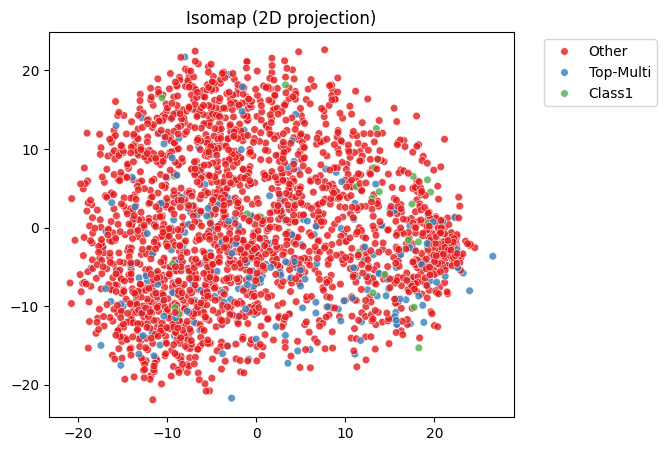

In [45]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_iso[:,0], 
    y=X_iso[:,1], 
    hue=df["Y_simple"], 
    palette="Set1", 
    s=30, alpha=0.8
)
plt.title("Isomap (2D projection)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### In the Isomap plot, most of the points are red ('Other'), forming one large continuous cluster that spreads smoothly acroos the space. This shows that most samples share a similar overall structure.

##### The blue ('Top-Multi') and green ('Class1') points are scattered among the red ones rather than forming their own clear groups. This suggests that their features overlap quite a it with the 'Other' class - the differences between them are more subtle and not strongly separated at a global level.

------------------------------------------------------------------------------------------------------------------------------------------------------

#### t-SNE vs Isomap Visualization

##### When comparing the Isomap and t-SNE plots, both methods help to understand the structure of the gene expression data but from different perspectives.

##### The t-SNE visualization focuses on local relationships - it pulls together points that are very similar in feature space and separates those that are quite different. As a result, it creates tight, well-defined clusters that make it easy to see small groups or subpopulations within the data. However, t-SNE often distorts the global structure: distances between clusters do not necessarily reflect how far apart they are in original high-dimensional space. This makes t-SNE excellent for exploring local detail, but less reliable for understanding the overall layout of the data. 

##### In contrast, Isomap aims to preserve the global geometry of the dataset. Instead of focusing only on immediate neighbors, it calculates 'geodesic distances' - the shortest paths along the manifold on which the data lies. This allows Isomap to maintain a sense of how all points relate to each other across the dataset. The resulting 2D projection appears smoother and more connected, showing a continuous structure rather than separate, isolated clusters.

##### From the visualizations, we can conclude that Isomap is better at revealing the global struture of the gene expression data. It gives a clearer sense of the overall data landscape, helping us understand how different regions of the dataset connect and transition into each other. Meanwhile, t-SNE is more suited for identifying local clusters or similar expression profiles within smaller groups.

----------------------------------------------------------------

#### Data Manifold - Its Complexity relation to Classification

##### The data manifold refers to lower-dimensional surface on which high-dimensional data points actually lie. Even though gene expression data may have thousands of features, the true relationships between samples often exist along a curved, structured surface - the manifold - embedded in that high-dimensional space. Dimensionality reduction techniques like Isomap help uncover and visualize this underlying shape.

##### Looking at Isomap visualization, the data appears to spread smoothly but with visible twists and bends rather than forming a flat plane. This suggests that the gene expression data lies on a highly curved and complex manifold. The smooth transitions indicate continuity between samples, while the non-linear layout shows that the underlying structure cannot be captured well by simple linear models.

##### A more complex or curved manifold means that the relationships between classes are non-linear - boundaries between twist and fold in high-dimensional space. As a result, classification becomes more challenging, especially for simple algorithms like linear classifiers, which assume straight, flat separations. Models may struggle to find clear decision boundaries and could misclassify samples that lie near curved regions of overlap.

##### In essence, the complexity of the manifold in the Isomap plot highlights why non-linear or more advanced models are often needed to accurately classify such gene expression data.

------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------